In [1]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [2]:
using Revise 
using GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots, StableRNGs
using Flux, Zygote, ForwardDiff
using BenchmarkTools
pgfplotsx()
import KernelFunctions: Matern52Kernel, SqExponentialKernel, with_lengthscale
import ReactiveMP: prod 

  ** incremental compilation may be fatally broken for this module **



  ** incremental compilation may be fatally broken for this module **



In [3]:
Random.seed!(2)
xmin, xmax = -3, 3  # Bounds of the data
N = 10# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=20));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func(θ) =  with_lengthscale(SqExponentialKernel(),θ) 
mean_func   = (x) -> 0.0;
θ_init = 4.0 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(FITC(5))  # 10 is the number of inducing points

CovarianceMatrixStrategy{FullyIndependentTrainingConditional{MersenneTwister}}(FullyIndependentTrainingConditional{MersenneTwister}(5, MersenneTwister(1), [1.0;;], [1.0;;], [1.0;;], [1.0;;], [1.0;;], [1.0;;]))

In [8]:
# test new thing
@model function gpprocess(n,kernelfunc,meanfunc,train,test,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train,strategy)
    ### change here 
    θ ~ NormalMeanVariance(log_θ_init, 2.)
    x ~ GaussianProcess(meanfunc,kernelfunc, θ) where {meta = CVI(StableRNG(42), 10,10,ADAM(0.1),ZygoteGrad()), 
                        pipeline = RequireMarginal(params)}
    #######
    γ ~ GammaShapeRate(.01,0.01)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
    end
end

In [9]:
@constraints function gpconstraints()   
    q(x,γ,θ) = q(x)q(γ)q(θ)
end

gpconstraints (generic function with 1 method)

In [10]:
nits = 1
iresult = inference(
    model = gpprocess(length(ytrain), k_func, mean_func, xtrain,xtest, cov_strategy),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),θ = NormalMeanVariance(log_θ_init, 2.)),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,)
    # free_energy = true,
    # showprogress = true
)

In [15]:
exp.(mean.(iresult.posteriors[:θ]))

UndefVarError: UndefVarError: iresult not defined

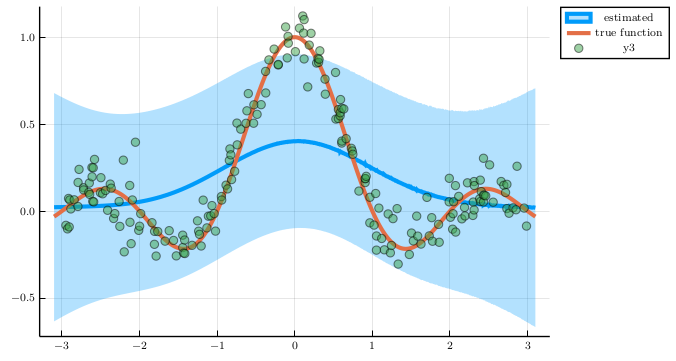

In [59]:
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

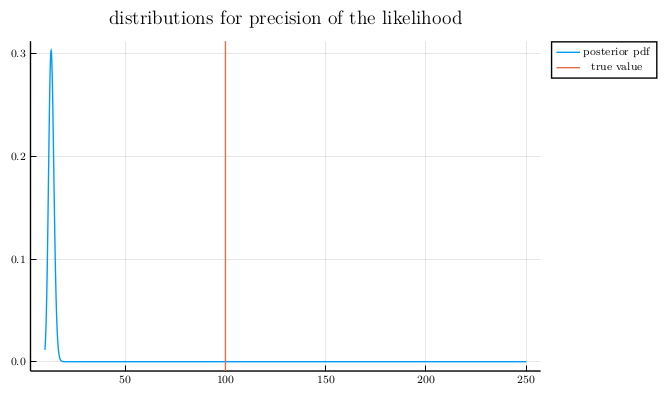

In [60]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)